In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scaling import analysis

In [5]:
models = {'lognormal_delta_fixed': analysis.LogNormalFixedDAnalysis,
          'lognormal_delta_fixed_beta_fixed': analysis.LogNormalFixedDFixedBetaAnalysis,
          'lognormal': analysis.LogNormalAnalysis,
          'lognormal_beta_fixed': analysis.LogNormalFixedBetaAnalysis,
          'gaussian_delta_fixed': analysis.FixedDAnalysis,
          'gaussian_delta_fixed_beta_fixed': analysis.FixedDFixedBetaAnalysis,
          'gaussian': analysis.ConstrainedDAnalysis,
          'gaussian_beta_fixed': analysis.ConstrainedDFixedBetaAnalysis,
          'person': analysis.PopulationAnalysis,
          'person_beta_fixed': analysis.PopulationFixedGammaAnalysis}

In [4]:
commute = pd.read_csv('sorted_data.csv')
population = pd.read_csv('population_sorted.csv')
merge = commute.merge(population, left_on='Local Authority', right_on='Local Authority', how='inner')

In [7]:
# Attractiveness
c_in = merge['c_in'].tolist()
# Population
c_stay = merge['c_stay'].tolist()
# Inbound Commuters
c_out = merge['c_out'].tolist()

resident_workforce = (merge['c_stay'] + merge['c_out']).tolist()

p = merge['Population'].tolist()

y_values = [('Visitor Workforce (C_in)', c_in), ('C_stay', c_stay), ('C_out', c_out), ('Resident Workforce', resident_workforce)]

x = p
start_i = 24

In [7]:
i = start_i
key = []
for y in y_values:
    data_xy = (x, y[1])
    relationship = ('Population against '+y[0])

    print(str(i) + ': ' + relationship)

    results = []
    for m in models:
        model = models[m]
        r = model(data_xy, required_successes=50)
        beta, beta_ci = r.beta
        bic = r.bic
        params = list(r.params)
        pv = r.p_value
        row = {
            'Model': m,
            'Beta': beta,
            'Beta_CI': beta_ci,
            'BIC': bic,
            'P_Value': pv,
            'Param1': params[0] if len(params) >= 1 else "",
            'Param2': params[1] if len(params) >= 2 else "",
            'Param3': params[2] if len(params) >= 3 else "",
            'Param4': params[3] if len(params) >= 4 else "",
        }
        results.append(row)
        print(row)

        df = pd.DataFrame(results)
        sorted_df = df.sort_values(by='BIC')
        sorted_df.to_csv((str(i)+'.csv'), index=False)
        best_model = sorted_df.loc[0, 'Model']
        key.append({'key': str(i), 'relationship': relationship, 'best_model': best_model})
        i += 1

    key_df = pd.DataFrame(key)
    key_df.to_csv('relationship_key2.csv', index=False)

plt.scatter(*data_xy, color='red', s=2.)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(y[0])
plt.xlabel('Population')
plt.title(relationship)
    
plt.show()

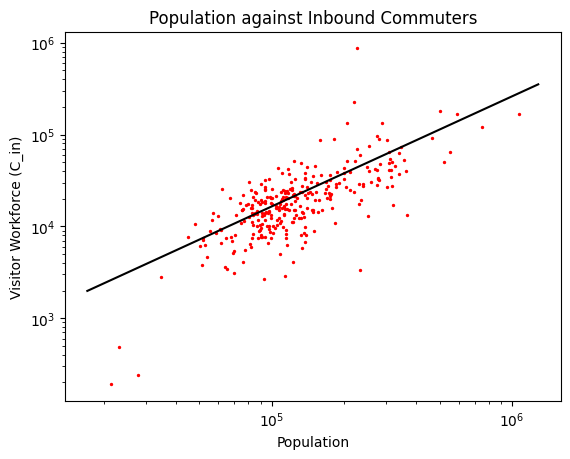

1.1976120703881683 0.176719072788135


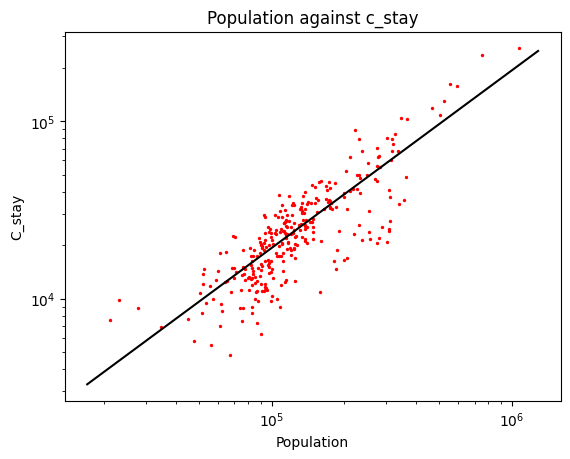

1.0 0.0


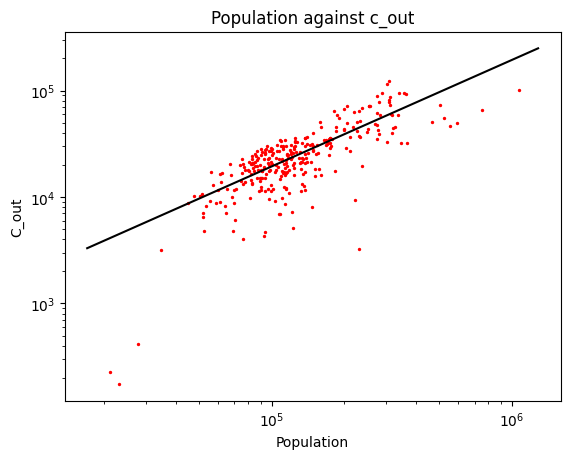

1.0 0.0


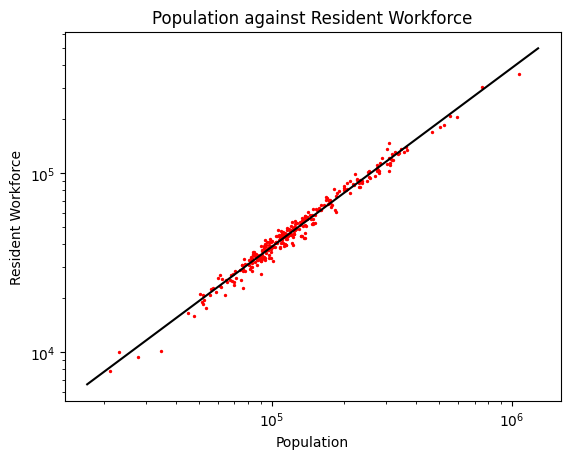

1.0 0.0


In [8]:
key = pd.read_csv('relationship_key.csv')

i = start_i
for x in [p]:
    for y in y_values:
        data_xy = (x, y[1])
        data_xy = np.array(data_xy)
        rmodel = key.loc[i, 'best_model']
        relationship = key.loc[i, 'relationship']
        result = pd.read_csv(str(i) + '.csv')
        model_row = result[result['Model'] == rmodel]

        # Get the values of the columns in the filtered row
        beta = model_row['Beta'].iloc[0]
        beta_ci = model_row['Beta_CI'].iloc[0]
        bic = model_row['BIC'].iloc[0]
        alpha = model_row['Param1'].iloc[0]
        
        line = 10**np.linspace(np.log10(data_xy[0].min()*0.8), np.log10(data_xy[0].max()*1.2), len(x))
        mean = alpha*np.power(line, beta)

        plt.scatter(*data_xy, color='red', s=2.)
        plt.plot(line, mean, color='k')
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel(y[0])
        plt.xlabel('Population')
        plt.title(relationship)

        plt.show()

        print(beta, beta_ci)
        i += 1